# Mixtures of Gaussian processes with GPclust


This notebook accompanies the paper

**Nonparameteric Clustering of Structured Time Series**  
_James Hensman, Magnus Rattray and Neil D. Lawrence_  
IEEE TPAMI 2014

The code is available at <https://github.com/jameshensman/gpclust> . The GPclust module depends on [GPy](https://github.com/SheffieldML/GPy).  

The hierachical Gaussian process model was fleshed out in 

**Hierarchical Bayesian modelling of gene expression time series  
across irregularly sampled replicates and clusters**  
_James Hensman, Neil D. Lawrence and Magnus Rattray_

http://www.biomedcentral.com/1471-2105/14/252

A simple implementation of hierarchical GPs is available as part of GPy. You may also be interested in the related notebook on hierarchical GPs.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
import numpy as np
import GPy
import sys
sys.path.append('/home/james/work/gpclust/')
import GPclust

## A simple sinusoid dataset

Here's a simulated dataset that contains the simple features that we expect to have in real data sets: smooth processes (here, sinusoids) corrupted by further smooth processes (here, more sinusoids) as well as noise. 

In [2]:
#generate a data set. Here's the sinusoid demo from the manuscript.
Nclust = 10
Nx = 12
Nobs = [np.random.randint(20,31) for i in range(Nclust)] #a random number of realisations in each cluster
X = np.random.rand(Nx,1)
X.sort(0)

#random frequency and phase for each cluster
base_freqs = 2*np.pi + 0.3*(np.random.rand(Nclust)-.5)
base_phases = 2*np.pi*np.random.rand(Nclust)
means = np.vstack([np.tile(np.sin(f*X+p).T,(Ni,1)) for f,p,Ni in zip(base_freqs,base_phases,Nobs)])

#add a lower frequency sinusoid for the noise
freqs = .4*np.pi + 0.01*(np.random.rand(means.shape[0])-.5)
phases = 2*np.pi*np.random.rand(means.shape[0])
offsets = 0.3*np.vstack([np.sin(f*X+p).T for f,p in zip(freqs,phases)])
Y = means + offsets + np.random.randn(*means.shape)*0.05

In the plot below, we show the underlying function for each cluster as a smooth red function, and the data associated with the cluster as thinly connected blue crosses. 

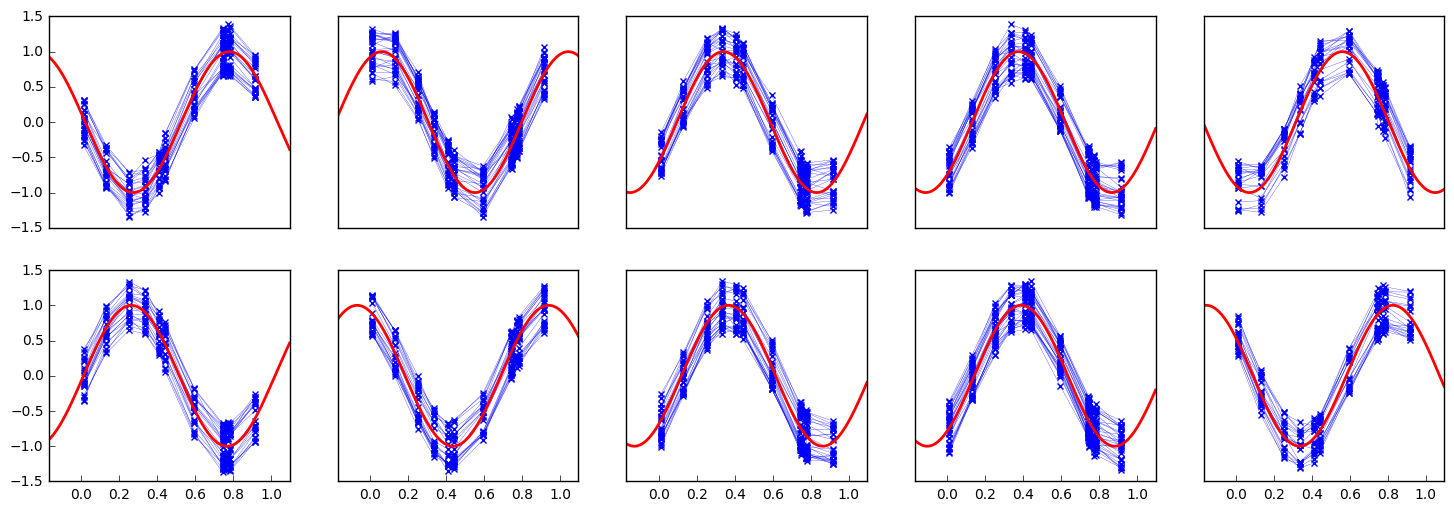

In [3]:
#plotting. 
x_plot, xmin, xmax = GPy.plotting.matplot_dep.base_plots.x_frame1D(X)
plt.figure(figsize=(18,6))
index_starts = np.hstack([0, np.cumsum(Nobs[:-1])])
index_stops = np.cumsum(Nobs)
for n in range(Nclust):
    plt.subplot(2,Nclust/2, n+1)
    plt.plot(X, Y[index_starts[n]:index_stops[n]].T, 'b', marker='x',ms=4, mew=1, linewidth=0.2)
    plt.plot(x_plot, np.sin(base_freqs[n]*x_plot+base_phases[n]), 'r', linewidth=2)
    
GPy.plotting.matplot_dep.base_plots.align_subplots(2, int(Nclust/2), xlim=(xmin, xmax))
    

##Constructing and optimizing a model

Now that we have generated a data set, it's straightforward to build and optimize a clustering model. First, we need to build two GPy kernels (covariance functions), which will be used to model the underlying function and the replication noise, respecively. We'll take a wild stab at the parameters of these covariances, and let the model optimize them for us later. 

The two kernels model the *underlying* function of the cluster, and the deviations of each gene from that underlying function. If we believe that the only corruption of the data from the cluster mean is i.i.d. noise, we can specify a `GPy.kern.White` covariance. In practise, it's helpful to allow correlated noise. The model of any cluster of genes then has a hierarchical structure, with the unknown cluster-specific mean drawn from a GP, and then each gene in that cluster being drawn from a GP with said unknown mean function. 

To optimize the model with the default optimization settings, we call m.optimize(). To invoke the recommended merge-split procedure, call m.systematic_splits(). Note that during the splitting procedure, many calls are made to the optimize function. 

In [4]:
k_underlying = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=0.1)
k_corruption = GPy.kern.RBF(input_dim=1, variance=0.01, lengthscale=0.1) + GPy.kern.White(1, variance=0.001)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, K=10, prior_Z='DP', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

iteration 1 bound=-2473.33618078 grad=38820.380732, beta=0
iteration 2 bound=-644.728660921 grad=21343.1968828, beta=0.0738876743231
iteration 3 bound=-569.499214642 grad=346.593655519, beta=0.0272989856558
iteration 4 bound=-568.969645922 grad=0.603419773676, beta=0.0
iteration 5 bound=-568.369510288 grad=0.217830356439, beta=1.35243272734
iteration 6 bound=-568.16519697 grad=0.197836288145, beta=0.0
iteration 7 bound=-568.033299036 grad=0.128637851712, beta=0.35227189222
iteration 8 bound=-567.930045748 grad=0.152426382889, beta=0.0
iteration 9 bound=-567.896019932 grad=0.0436721062247, beta=0.269890691527
iteration 10 bound=-567.89334807 grad=0.00376773329088, beta=0.162067845223
iteration 11 bound=-567.893289365 grad=0.000111868531094, beta=0.0
iteration 13 bound=-567.893289234 grad=1.64261168295e-06, beta=0.105676481778
vb converged (ftol)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


iteration 14 bound=2241.5409093 grad=1.1638745299, beta=931.115445091
iteration 16 bound=2246.58369283 grad=5.27606942354, beta=93.0187845679
iteration 17 bound=2254.46730823 grad=14.1574064917, beta=1.19802456932
iteration 18 bound=2254.53816199 grad=4.10135041445, beta=0.0265222655155
iteration 19 bound=2254.538162 grad=2.25219033361e-08, beta=2.15811217925e-07
vb converged (ftol)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installe

In [5]:
print(X.shape, Y.shape)
print(X)

(12, 1) (247, 12)
[[ 0.01076319]
 [ 0.12914777]
 [ 0.25174137]
 [ 0.3353771 ]
 [ 0.40863114]
 [ 0.44137079]
 [ 0.59405248]
 [ 0.74297146]
 [ 0.74663639]
 [ 0.77347294]
 [ 0.78311614]
 [ 0.91536511]]


##Plotting and examining the posterior
The model has quite extensive plotting built in, with various options for colour, display of the data as points or connected lines, etc. Here we find that the model manages to separate all but two of the true clusters. The number of 'genes' found in each cluster is labeled in the corner of each plot. 

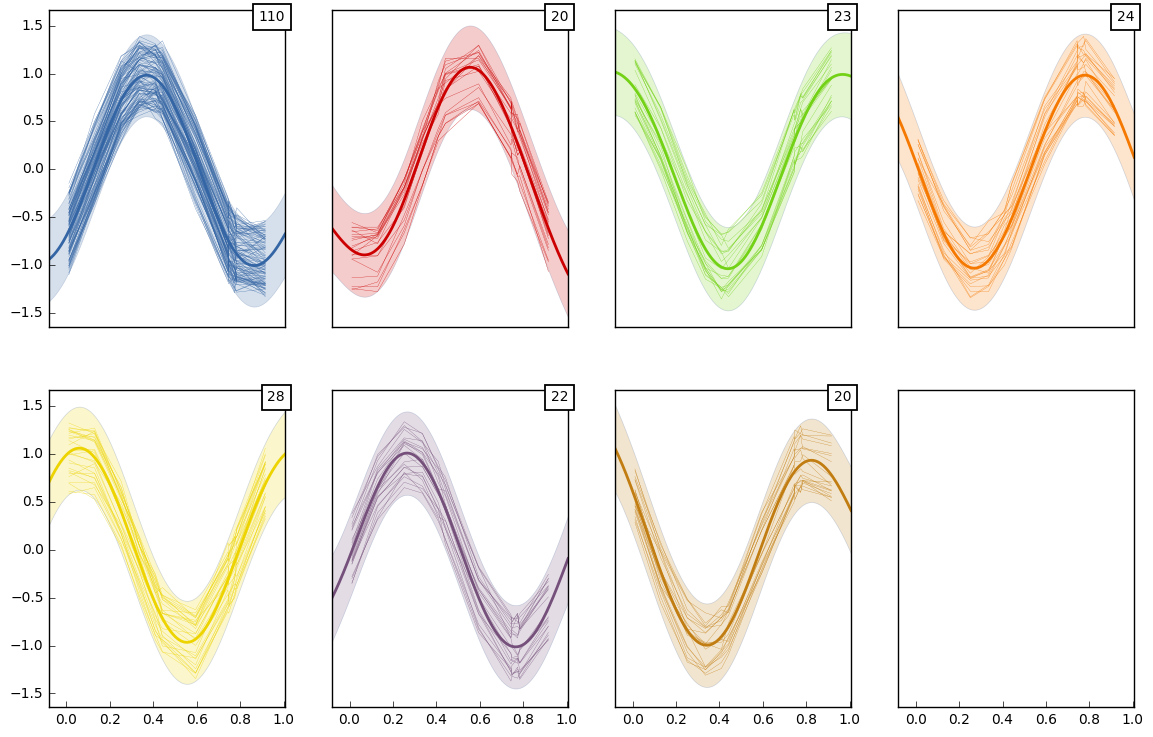

In [6]:
plt.figure(figsize=(14,9))
m.plot(on_subplots=True, colour=True, newfig=False)

#Structure is important
Why do we have to specify two kernels in GPclust? The first kernel describes the properties of the functions which underly each cluster. The second describes the properties of the functions which describe how each time-course (gene) deviates from the cluster. 

This structure is important: if we model the deviation of each time-course from the cluster as simply noise, it's more difficult to infer the correct clusters. Such a model can be constructed in GPclust by using a white (noise) kernel for the structure, as follows.


In [7]:
#exactly as above, but with a white-noise kernel for the structure.
k_underlying = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=0.1)
k_corruption = GPy.kern.White(1, variance=0.1)

m = GPclust.MOHGP(X, k_underlying, k_corruption, Y, K=10, prior_Z='DP', alpha=1.0)
m.optimize()
m.systematic_splits(verbose=False)

iteration 1 bound=-2008.82449019 grad=1971.10346787, beta=0
iteration 2 bound=-854.94501651 grad=8831.70584826, beta=0.427284660003
iteration 3 bound=-779.723824583 grad=313.976394913, beta=0.0
iteration 4 bound=-762.401150451 grad=30.6886268575, beta=0.0
iteration 5 bound=-759.359762157 grad=15.4962451562, beta=0.0779394051359
iteration 6 bound=-756.509598933 grad=2.63759302042, beta=0.0
iteration 7 bound=-749.958446337 grad=3.49427047529, beta=1.50820430545
iteration 8 bound=-748.086748249 grad=2.13566434706, beta=0.0
iteration 9 bound=-746.15383341 grad=1.87913663004, beta=0.0
iteration 10 bound=-740.129238041 grad=2.87238846051, beta=1.26968411273
iteration 11 bound=-724.759012754 grad=13.1776568443, beta=1.37846237187
iteration 12 bound=-719.206446156 grad=24.3919279703, beta=0.178354048989
iteration 13 bound=-708.599796948 grad=14.6262752591, beta=0.0
iteration 14 bound=-707.267561425 grad=33.3493731042, beta=0.286429501579
iteration 15 bound=-707.267263583 grad=0.000518498043524

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installe

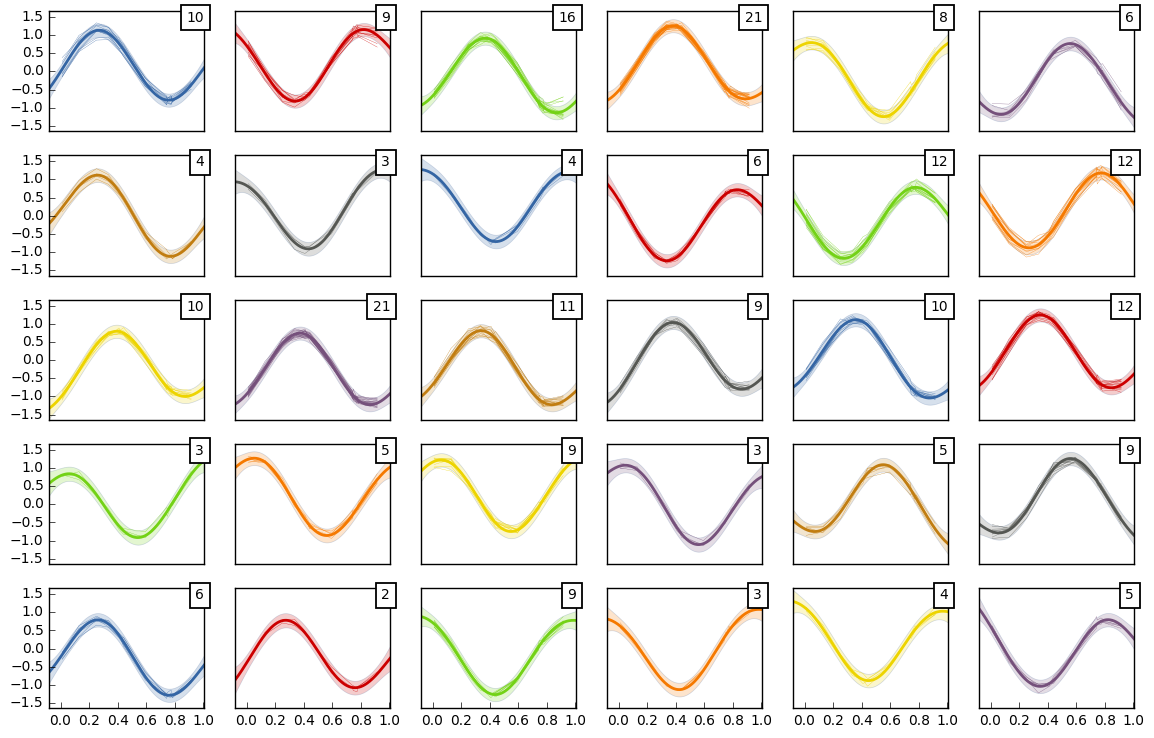

In [8]:
plt.figure(figsize=(14,9))
m.plot(on_subplots=True, colour=True, newfig=False)

Here we can see that the procedure finds too many clusters (we know that the ground truth is that there are 10). This is because without the ability to model the deviation from the cluster mean in a structured fashion, that structure appears as additional clusters. 

This point is exaggerated a little by the toy data that we have generated, but the same issue exists in real data. For more details and consideration of the cluster structure, see the subsequent notebook on clustering Drosophila development. 